# Week 5 - Non-linear regression models 

Hello again. In this notebook we will focus on non-linear regression models, specifically using **Neural Networks**!

The usual imports...

In [1]:
# First, we need to download an auxiliary Python file for STAN
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

--2020-02-22 19:50:31--  http://mlsm.man.dtu.dk/mbml/pystan_utils.py
Resolving mlsm.man.dtu.dk (mlsm.man.dtu.dk)... 192.38.87.226
Connecting to mlsm.man.dtu.dk (mlsm.man.dtu.dk)|192.38.87.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/x-python]
Saving to: ‘pystan_utils.py’

pystan_utils.py     100%[===================>]   2.60K  --.-KB/s    in 0s      

2020-02-22 19:50:32 (354 MB/s) - ‘pystan_utils.py’ saved [2661/2661]



In [0]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [0]:
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

## Generate non-linear dataset (for regression)

We start by generating some artificial data that we will be using in this notebook (just for the purpose of demonstration :-)

We will assume that our inputs $\textbf{x}$ are 2-dimensional, so $\textbf{x} = \{x_1, x_2\}$

In [0]:
X = np.random.rand(300,2) 
N, D = X.shape
print("Vector of", N, "x", D)

Vector of 300 x 2


Now we are going generate the corresponding targets $y$ (which we will later try to predict). We will do it in a special way. Namely, we will assume that the target variable $y$ is a linear function of the first input dimension $x_1$, and a complex non-linear function of the second dimension $x_2$ (a sine function in this case).

The target variables are the defined as
\begin{align}
y = \beta \, x_1 + \sin(\gamma \, x_2) + \epsilon
\end{align}
where $\epsilon$ is an additive white noise term $\epsilon \sim \mathcal{N}(0, \sigma^2)$

Let us now pre-define some values for $\beta$, $\gamma$ and $\sigma^2$, and generate the $y$'s. Make sure that you understand the following code:

In [0]:
# we assume sigma^2 to be fixed
sigma2 = 0.1
print("sigma^2:", sigma2)

# sample coefficient beta
#beta = np.random.normal(5,0.1,size=1)
beta = 2
print("beta:", beta)

# sample coefficient gamma
#gamma = np.random.normal(10,0.1,size=1)
gamma = 10
print("gamma:", gamma)

# sample observations (y's)
y = np.zeros(N)
for n in range(N):
    y[n] = np.random.normal(beta * X[n,0] + np.sin(gamma * X[n,1]), sigma2)
    print("y[%d]: %.3f" % (n, y[n]))

sigma^2: 0.1
beta: 2
gamma: 10
y[0]: 0.614
y[1]: 1.092
y[2]: 1.301
y[3]: 0.704
y[4]: 1.863
y[5]: -0.350
y[6]: 2.713
y[7]: 1.333
y[8]: -0.322
y[9]: 1.113
y[10]: 2.197
y[11]: 0.064
y[12]: 1.974
y[13]: -0.434
y[14]: 1.580
y[15]: 2.148
y[16]: 0.039
y[17]: 2.675
y[18]: 1.286
y[19]: 0.553
y[20]: -0.563
y[21]: 0.369
y[22]: 0.911
y[23]: -0.229
y[24]: 2.363
y[25]: 3.046
y[26]: 2.325
y[27]: 1.305
y[28]: 0.942
y[29]: -0.001
y[30]: 1.117
y[31]: 1.102
y[32]: -0.258
y[33]: 1.160
y[34]: -0.112
y[35]: 2.547
y[36]: 0.965
y[37]: 2.407
y[38]: 2.225
y[39]: 1.547
y[40]: 1.828
y[41]: 1.309
y[42]: 0.408
y[43]: 1.532
y[44]: 0.687
y[45]: 0.852
y[46]: 0.993
y[47]: 0.758
y[48]: -0.000
y[49]: 0.989
y[50]: 0.079
y[51]: -0.351
y[52]: 2.360
y[53]: 1.690
y[54]: 1.158
y[55]: 1.496
y[56]: 2.861
y[57]: 1.914
y[58]: 2.540
y[59]: 0.917
y[60]: 2.005
y[61]: 1.603
y[62]: -0.398
y[63]: 2.268
y[64]: -0.899
y[65]: 1.706
y[66]: -0.160
y[67]: 1.850
y[68]: 1.651
y[69]: 0.495
y[70]: 2.433
y[71]: 0.946
y[72]: 0.767
y[73]: 0.273
y[74

Let us now try to visualize the data that we just generated. In order to keep everything in 2D, we will use the 2 axes of the plot for the values of $x_1$ and $x_2$, and use a color map to represent the corresponding values of $y$ for each point. Make sure that you understand what you are seeing :-)

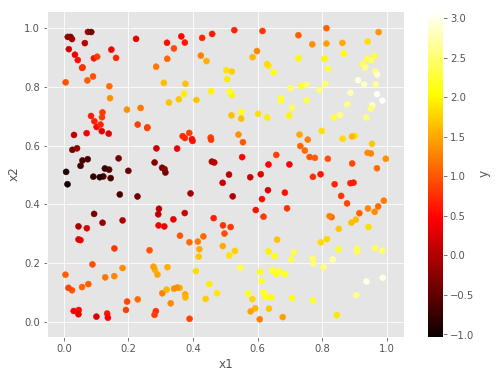

In [0]:
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.hot)
plt.colorbar(sc, label="y")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

From the plot above, we can observe that the value of $y$ (i.e. the color) increases linearly over the $x_1$ axis (for the same value of $x_2$). However, over the $x_2$ dimension, the pattern in highly non-linear. That makes perfect sense given the way the data was generated, right?

Let us now split our generated data in a trainset and testset. We then fit a simple linear regression model on the trainset, and see how it performs on the testset. What do you think will happen? 

In [0]:
# train/test split
X_train = X[:100,:]
y_train = y[:100]
X_test = X[100:,:]
y_test = y[100:]

In [0]:
from sklearn import datasets, linear_model

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X, y)
preds_lr = regr.predict(X_test)
print(regr.coef_)

[2.29159436 0.02323962]


We can already observe that the coefficient $\beta$ for the first dimension $x_1$ (which was actually linear!!) is already not being estimated very well (2.29 estimated vs 2.0 true value used to generate the data). The coefficient for the second dimension is hard to make much sense of it... It is close to zero, as if that dimension wasn't very relevant for the values of $y$ that are observed...

Let's have a look at the mean absolute error (MAE) for the predictions:

In [0]:
mae = np.mean(np.abs(y_test-preds_lr))
print("MAE:", mae)

MAE: 0.5810531113848185


A bit high given the range of the $y$ values...

Perhaps we can get a better intuition about the quality of the predictions of the linear regression model if we try to visualize them:

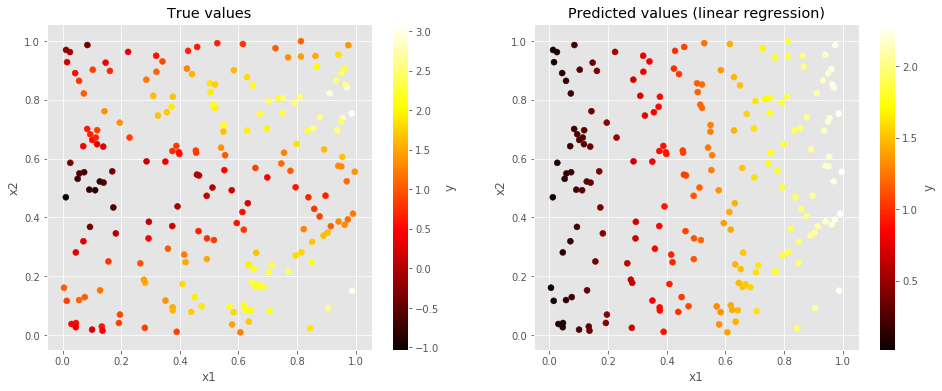

In [0]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test[:,0], X_test[:,1], c=preds_lr, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear regression)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

Comparing the true values (left) with the predicted ones (right), we can see that linear regression is making a really poor job at modelling the values of $y$ given the inputs $\{x_1,x_2\}$. It captures a bit the increasing trend over the $x_1$ dimension, but not much beyond that.

A few more plots to investigate the problem a bit further:

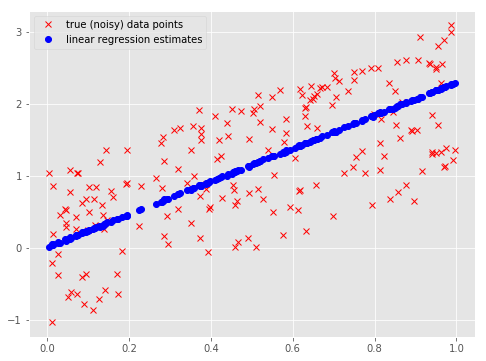

In [0]:
plt.plot(X_test[:,0], y_test, "rx")
plt.plot(X_test[:,0], preds_lr, 'bo')
plt.legend(["true (noisy) data points", "linear regression estimates"])
plt.show()

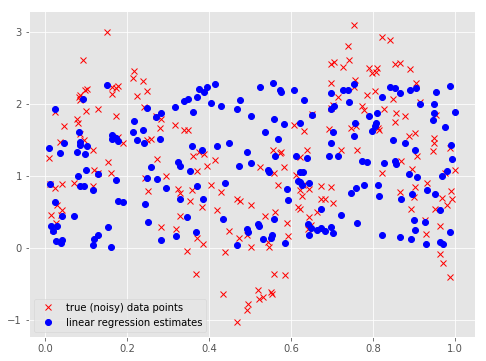

In [0]:
plt.plot(X_test[:,1], y_test, "rx")
plt.plot(X_test[:,1], preds_lr, 'bo')
plt.legend(["true (noisy) data points", "linear regression estimates"])
plt.show()

## Neural Network model in STAN

As mentioned in the lecture's slides, we can obtain complex non-linear function of the inputs by making use of Neural Networks! The following code implements a multi-layer fully-connected NNet in STAN. It looks a bit big and scary, but if you look closely, you will see that it is not that complicated :-) See if you can understand what it is doing:

(Disclaimer: In practice, STAN is not the right place to be developing neural networks! There are much better frameworks for doing that (Tensorflow, Keras, PyTorch, etc.). But for the purpose of this lecture, it will do the job :-) Plus, it will allow us for a Bayesian treatment of Neural Networks...)

In [0]:
model_definition = """
functions {
  vector NNet(matrix X, vector bias_first, vector[] bias_hidden, real bias_output, 
                matrix w_first, matrix[] w_hidden, vector w_output, int num_hidden_layers) {
    int N = rows(X);
    int num_neurons = rows(w_first);
    matrix[N, num_neurons] layer_values[num_hidden_layers];
    vector[N] nnet_output;

    layer_values[1] = tanh(rep_matrix(bias_first',N) + X * w_first');   
    for(i in 2:(num_hidden_layers)) 
      layer_values[i] = tanh(rep_matrix(bias_hidden[i-1]',N) + layer_values[i-1] * w_hidden[i-1]');
    nnet_output = bias_output + layer_values[num_hidden_layers] * w_output;

    return nnet_output;
  }
}
data {
  int<lower=0> N;
  int<lower=0> D;
  int<lower=0> num_neurons;
  int<lower=0> num_hidden_layers;
  matrix[N,D] X;
  real y[N];
  int<lower=0> Ntest;
  matrix[Ntest,D] Xtest;
}
parameters {
  // neural network parameters
  vector[num_neurons] bias_first;
  vector[num_neurons] bias_hidden[num_hidden_layers-1];
  real bias_output;
  matrix[num_neurons, D] w_first;
  matrix[num_neurons, num_neurons] w_hidden[num_hidden_layers-1];
  vector[num_neurons] w_output;
}
model{
  vector[N] nnet_output;
  
  // priors over neural network biases
  bias_first ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    bias_hidden[i] ~ normal(0, 1);
  }
  bias_output ~ normal(0, 1);

  // priors over neural network weights
  to_vector(w_first) ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    to_vector(w_hidden[i]) ~ normal(0, 1);
  }
  w_output ~ normal(0, 1);
  
  // likelihood
  nnet_output = NNet(X, bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
  y ~ normal(nnet_output, 0.1);
}
generated quantities{
  vector[Ntest] predictions;
  {
    vector[Ntest] nnet_output;
    nnet_output = NNet(Xtest, bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
    for(i in 1:Ntest) 
      predictions[i] = nnet_output[i];
  }
}
"""

Using the STAN model above, we could fit a Neural Network to our non-linear dataset from above, and it will likely be able to fit it much better than the simple linear regression model. However, we will do something different here.

Assume that we are actually interested in investigating how $x_1$ affects $y$ (e.g., imagine $y$ is the price of a house and $x_1$ is the square footage), but not so much about the effect of $x_2$. You could use a NNet to model the relationship of $y$ with both $x_1$ and $x_2$, however, NNets are black-boxes that are pretty hard to interpret. So, we are at a crossroads: we can either have a simple linear model (interpretable!) or a complex neural network (black-box). But can we combine both?? :-)

In order to analyse the effect of $x_1$ of $y$, we will explore the combination of PGMs and (Bayesian) Neural Networks! To do so, we will a assume a model of the following form:

\begin{align}
y = \beta \, x_1 + \mbox{NNet}(x_2) + \epsilon
\end{align}

In other words, we use a simple linear regression for modelling the relationship with $x_1$, and a Bayesian neural network for $x_2$.

Can you modify the STAN code of the neural network above in order to implement this variation of the model?

In [0]:
model_definition = """
functions {
  vector NNet(matrix X, vector bias_first, vector[] bias_hidden, real bias_output, 
                matrix w_first, matrix[] w_hidden, vector w_output, int num_hidden_layers) {
    int N = rows(X);
    int num_neurons = rows(w_first);
    matrix[N, num_neurons] layer_values[num_hidden_layers];
    vector[N] nnet_output;

    layer_values[1] = tanh(rep_matrix(bias_first',N) + X * w_first');   
    for(i in 2:(num_hidden_layers)) 
      layer_values[i] = tanh(rep_matrix(bias_hidden[i-1]',N) + layer_values[i-1] * w_hidden[i-1]');
    nnet_output = bias_output + layer_values[num_hidden_layers] * w_output;

    return nnet_output;
  }
}
data {
  int<lower=0> N;
  int<lower=0> D;
  int<lower=0> num_neurons;
  int<lower=0> num_hidden_layers;
  matrix[N,D] X;
  real y[N];
  int<lower=0> Ntest;
  matrix[Ntest,D] Xtest;
}
parameters {
  // linear coefficients
  real beta;
  
  // neural network parameters
  vector[num_neurons] bias_first;
  vector[num_neurons] bias_hidden[num_hidden_layers-1];
  real bias_output;
  matrix[num_neurons, D-1] w_first;
  matrix[num_neurons, num_neurons] w_hidden[num_hidden_layers-1];
  vector[num_neurons] w_output;
}
model{
  vector[N] nnet_output;
  
  //prior over linear coefficients
  beta ~ normal(0, 1);
  
  // priors over neural network biases
  bias_first ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    bias_hidden[i] ~ normal(0, 1);
  }
  bias_output ~ normal(0, 1);

  // priors over neural network weights
  to_vector(w_first) ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    to_vector(w_hidden[i]) ~ normal(0, 1);
  }
  w_output ~ normal(0, 1);
  
  // likelihood
  nnet_output = NNet(X[:,2:], bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
  y ~ normal(beta * X[:,1] + nnet_output, 0.1);
}
generated quantities{
  vector[Ntest] predictions;
  {
    vector[Ntest] nnet_output;
    nnet_output = NNet(Xtest[:,2:], bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
    for(i in 1:Ntest) 
      predictions[i] = beta * Xtest[i,1] + nnet_output[i];
  }
}
"""

Data preparation and STAN model compilation:

In [0]:
# prepare data for Stan model
data = {'N': N, 'D': 2, 'num_neurons':4, 'num_hidden_layers':2, 
        'X': X, 'y': y, 'Ntest': len(X_test), 'Xtest': X_test}

In [0]:
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac9f7ba83385756a697777b63eb2b479 NOW.


## Now we can run inference using MCMC on the model that you just implemented:

In [0]:
fit = sm.sampling(data=data, iter=1000, chains=1, algorithm="NUTS", seed=42, verbose=True)

Let's have a look at the results:

In [0]:
print(fit)

Inference for Stan model: anon_model_ac9f7ba83385756a697777b63eb2b479.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta               2.02  3.8e-3   0.02   1.98    2.0   2.02   2.03   2.06     28   1.05
bias_first[1]      1.52    0.23    0.6   0.27   1.28   1.55   1.86   2.83      7   1.32
bias_first[2]     -0.44    0.18   0.61  -1.84  -0.73  -0.37  -0.04   0.49     11   1.07
bias_first[3]     -0.85    0.27   0.71  -2.17  -1.46  -0.73  -0.31   0.33      7   1.16
bias_first[4]     -0.32    0.11   0.67  -1.53  -0.79  -0.32   0.04   1.24     37    1.0
bias_hidden[1,1]  -0.25    0.14   0.78  -1.88  -0.79  -0.24   0.29   1.26     33   1.05
bias_hidden[1,2]  -0.22    0.17   0.84  -1.87  -0.72  -0.29   0.32   1.47     24   1.01
bias_hidden[1,3]   0.33    0.27   1.01  -1.79  -0.33   0.46   1.06   2.04     14   1.05
bias_hidden[1,4]  -0.4

Notice the estimated value for the coefficient $\beta$ over the input dimension $x_1$. Unlike with the linear regression model, we managed to recover the true value of $\beta$ that was used to generate the data ($\beta=2$)!!

What can we conclude from this? It seems that modelling more accuratly the relationship between $x_2$ and $y$ with the NNet, takes away some of the "burden" from the linear part of the model, which can then focus on modelling the effect of $x_1$ better! Makes sense, right?

But that is only part of the "story". Let us now look at the predictions for the testset:

In [0]:
preds_nnet_mcmc = np.mean(fit["predictions"], axis=0)

In [0]:
mae = np.mean(np.abs(y_test-preds_nnet_mcmc))
print("MAE:", mae)

MAE: 0.08072794341720582


Uau! That is quite a dramatic reduction in prediction error!!

Let's see if visually we can draw a similar conclusion:

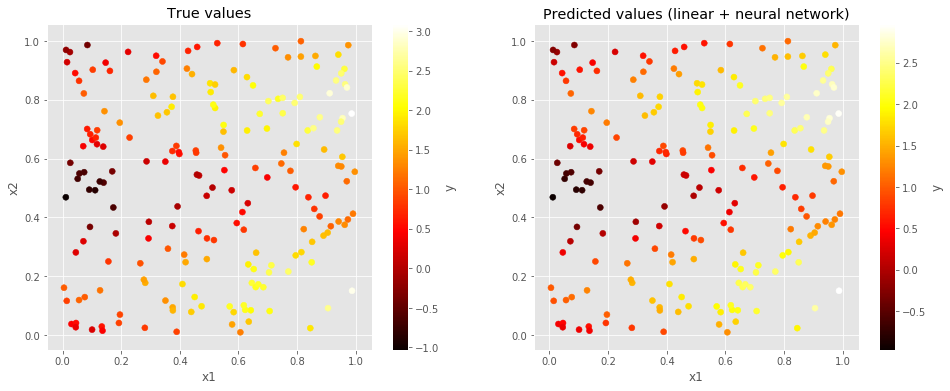

In [0]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test[:,0], X_test[:,1], c=preds_nnet_mcmc, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear + neural network)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

We can see that the composite model (Linear PGM + NNet) predicts almost perfectly the target variable $y$ for the testset! Notice that it managed to capture both the linear trend over the $x_1$ dimension and the complex non-linear trend on the $x_2$ dimension (the one that resulted from the sine function...).

A few more visualizations to analyse the quality of the predictions of the composite model (Linear PGM + NNet) in comparison with the predictions of the linear regression model:

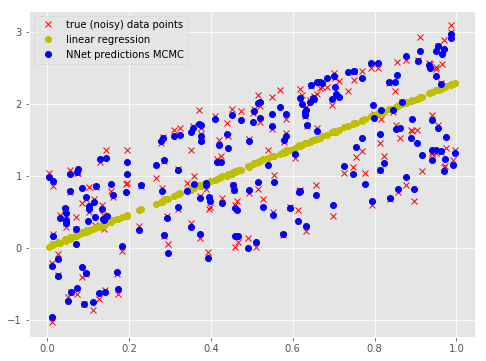

In [0]:
plt.plot(X_test[:,0], y_test, "rx")
plt.plot(X_test[:,0], preds_lr, 'yo')
plt.plot(X_test[:,0], preds_nnet_mcmc, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions MCMC"])
plt.show()

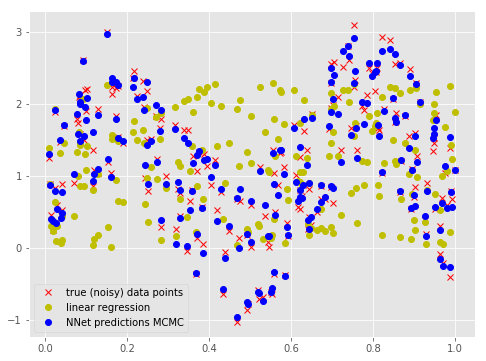

In [0]:
plt.plot(X_test[:,1], y_test, "rx")
plt.plot(X_test[:,1], preds_lr, 'yo')
plt.plot(X_test[:,1], preds_nnet_mcmc, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions MCMC"])
plt.show()

We hope you enjoyed this tutorial :-)